# 2-22: Intro to scikit-learn

<img src="https://www.cityofberkeley.info/uploadedImages/Public_Works/Level_3_-_Transportation/DSC_0637.JPG" style="width: 500px; height: 275px;" />
---

** Regression** is useful for predicting a value that varies on a continuous scale from a bunch of features. This lab will introduce the regression methods available in the scikit-learn extension to scipy, focusing on ordinary least squares linear regression, LASSO, and Ridge regression.

*Estimated Time: 45 minutes*

---


### Table of Contents


1 - [The Test-Train-Validation Split](#section 1)<br>

2 - [Linear Regression](#section 2)<br>

3 - [LASSO Regression](#section 3)<br>

4 - [Ridge Regression](#section 4)<br>

5 - [Choosing a Model](#section 5)<br>



**Dependencies:**

In [1]:
import numpy as np
from datascience import *
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold

## The Data: Bike Sharing

In your time at Cal, you've probably passed by one of the many bike sharing station around campus. Bike sharing systems have become more and more popular as traffic and concerns about global warming rise. This lab's data describes one such bike sharing system in Washington D.C., from [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [2]:
bike=Table().read_table(('data/Bike-Sharing-Dataset/day.csv'))

# reformat the date column to integers representing the day of the year, 001-366
bike['dteday'] = pd.to_datetime(bike['dteday']).strftime('%j')

# get rid of the index column
bike = bike.drop(0)

bike.show(4)

dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
001,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
002,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
003,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
004,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562


Take a moment to get familiar with the data set. In data science, you'll often hear rows referred to as **records** and columns as **features**. Before you continue, make sure you can answer the following:

- How many records are in this data set?
- What does each record represent?
- What are the different features?
- How is each feature represented? What values does it take, and what are the data types of each value?

Use Table methods and check the UC Irvine link for more information.

In [3]:
# explore the data set here

---
## 1. The Test-Train-Validation Split  <a id='section 1'></a>

When we train a model on a data set, we run the risk of [**over-fitting**](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html). Over-fitting happens when a model becomes so complex that it makes very accurate predictions for the data it was trained on, but it can't generalize to make good predictions on new data.

We can reduce the risk of overfitting by using a **test-train split**. 

1. Randomly divide our data set into two smaller sets: one for training and one for testing
2. Train the data on the training set, changing our model along the way to increase accuracy
3. Test the data's predictions using the test set.

Scikit-learn's [`test_train_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function will help here. First, separate your data into two parts: a Table containing the features used to make our prediction, and an array of the true values. To start, let's predict the *total number of riders* (y) using *every feature that isn't a rider count* (X).

Note: for the function to work, X can't be a Table. Save X as a pandas DataFrame by calling `.to_df()` on the feature Table.

In [4]:
# the features used to predict riders
X = bike.drop('casual', 'registered', 'cnt')
X = X.to_df()

# the number of riders
y = bike['cnt']

Next, set the random seed using `np.random.seed(...)`. This will affect the way numpy pseudo-randomly generates the numbers it uses to decide how to split the data into training and test sets. Any seed number is fine- the important thing is to document the number you used in case we need to recreate this pseudorandom split in the future.

Then, call `train_test_split` on your X and y. Also set the parameters `train_size=` and `test_size=` to set aside 80% of the data for training and 20% for testing.

In [5]:
# set the random seed

np.random.seed(10)

# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)

### The Validation Set

Our test data should only be used once: after our model has been selected, trained, and tweaked. Unfortunately, it's possible that in the process of tweaking our model, we could still overfit it to the training data and only find out when we return a poor test data score. What then?

A **validation set** can help here. By trying your trained models on a validation set, you can (hopefully) weed out models that don't generalize well.

Call `train_test_split` again, this time on your X_train and y_train. We want to set aside 25% of the data to go to our validation set, and keep the remaining 75% for our training set.

Note: This means that out of the original data, 20% is for testing, 20% is for validation, and 60% is for training.

In [6]:
# split the data
# Returns 4 values: X_train, X_validate, y_train, y_validate

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

## 2. Linear Regression (Ordinary Least Squares) <a id='section 2'></a>

Now, we're ready to start training models and making predictions. We'll start with a **linear regression** model.

[Scikit-learn's linear regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) is built around scipy's ordinary least squares, which you used in the last lab. The syntax for each scikit-learn model is very similar:
1. Create a model by calling its constructor function. For example, `LinearRegression()` makes a linear regression model.
2. Train the model on your training data by calling `.fit(train_X, train_y)` on the model

Create a linear regression model in the cell below.

In [7]:
# create a model
lin_reg = LinearRegression(normalize=True)

# fit the model
lin_model = lin_reg.fit(X_train, y_train)


With the model fit, you can look at the best-fit slope for each feature using `.coef_`, and you can get the intercept of the regression line with `.intercept_`.

In [8]:
print(lin_model.coef_)
print(lin_model.intercept_)

[  -14.18033852   476.05152957  2074.99361806   391.42859423
  -548.21392825    51.99824278    74.52205017  -654.9048012
 -3639.09456149 10029.50716836  -548.30835199 -2204.11280459]
840.1967135428949


Now, let's get a sense of how good our model is. We can do this by looking at the difference between the predicted values and the actual values, also called the error.

We can see this graphically using a scatter plot.

- Call `.predict(X)` on your linear regression model, using your training X and training y, to return a list of predicted number of riders per hour. Save it to a variable `lin_pred`.
- Using a scatter plot (`plt.scatter(...)`), plot the predicted values against the actual values (`y_train`)

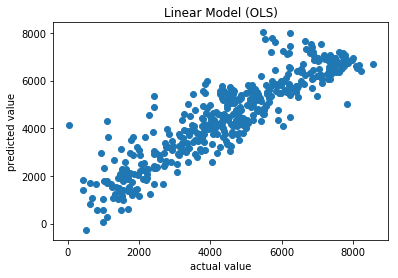

In [9]:
# predict the number of riders
lin_pred = lin_model.predict(X_train)

# plot the residuals on a scatter plot
plt.scatter(y_train, lin_pred)
plt.title('Linear Model (OLS)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

Question: what should our scatter plot look like if our model was 100% accurate?

**ANSWER:** All points (i.e. errors) would fall on a line with a slope of one: the predicted value would always equal the actual value.

We can also get a sense of how well our model is doing by calculating the **root mean squared error**. The root mean squared error (RMSE) represents the average difference between the predicted and the actual values.

To get the RMSE:
- subtract each predicted value from its corresponding actual value (the errors)
- square each error (this prevents negative errors from cancelling positive errors)
- average the squared errors
- take the square root of the average (this gets the error back in the original units)

Write a function `rmse` that calculates the mean squared error of a predicted set of values.

In [10]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

Now calculate the mean squared error for your linear model.

In [11]:
rmse(lin_pred, y_train)

854.5479409431215

## 3. Ridge Regression <a id='section 3'></a>

Now that you've gone through the process for OLS linear regression, it's easy to do the same for [**Ridge Regression**](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). In this case, the constructor function that makes the model is `Ridge()`.

In [12]:
# make and fit a Ridge regression model
ridge_reg = Ridge() 
ridge_model = ridge_reg.fit(X_train, y_train)


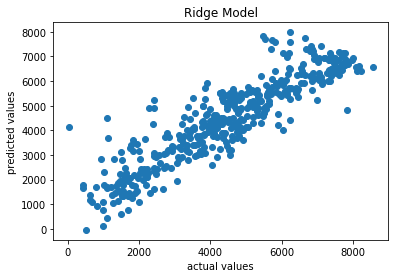

In [13]:
# use the model to make predictions
ridge_pred = ridge_model.predict(X_train)

# plot the predictions
plt.scatter(y_train, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [14]:
# calculate the rmse for the Ridge model
rmse(ridge_pred, y_train)

862.0018796318278

Note: the documentation for Ridge regression shows it has lots of **hyperparameters**: values we can choose when the model is made. Now that we've tried it using the defaults, look at the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) and try changing some parameters to see if you can get a lower RMSE (`alpha` might be a good one to try).

## 4. LASSO Regression <a id='section 4'></a>

Finally, we'll try using [LASSO regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). The constructor function to make the model is `Lasso()`. 

You may get a warning message saying the objective did not converge. The model will still work, but to get convergence try increasing the number of iterations (`max_iter=`) when you construct the model.


In [15]:
# create and fit the model
lasso_reg = Lasso(max_iter=10000)  

lasso_model = lasso_reg.fit(X_train, y_train)


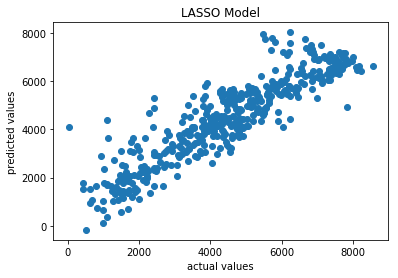

In [16]:
# use the model to make predictions
lasso_pred = lasso_model.predict(X_train)

# plot the predictions
plt.scatter(y_train, lasso_pred)
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [17]:
# calculate the rmse for the LASSO model
rmse(lasso_pred, y_train)

856.4246870534422

Note: LASSO regression also has many tweakable hyperparameters. See how changing them affects the accuracy!

Question: How do these three models compare on performance? What sorts of things could we do to improve performance?

**ANSWER:** All three models have very similar accuracy, around 900 RMSE for each.

We could try changing which features we use or adjust the hyperparameters.

---
## 5.  Choosing a model <a id='section 5'></a>
### Validation

Once you've tweaked your models' hyperparameters to get the best possible accuracy on your training sets, we can compare your models on your validation set. Make predictions on `X_validate` with each one of your models, then calculate the RMSE for each set of predictions.

In [18]:
# make predictions for each model
lin_vpred = lin_model.predict(X_validate)
ridge_vpred = ridge_model.predict(X_validate)
lasso_vpred = lasso_model.predict(X_validate)

In [19]:
# calculate RMSE for each set of validation predictions
print("linear model rmse: ", rmse(lin_vpred, y_validate))
print("Ridge rmse: ", rmse(ridge_vpred, y_validate))
print("LASSO rmse: ", rmse(lasso_vpred, y_validate))

linear model rmse:  851.1432410273447
Ridge rmse:  850.120677097078
LASSO rmse:  847.6822999450299


How do the RMSEs for the validation data compare to those for the training data? Why?

Did the model that performed best on the training set also do best on the validation set?

**YOUR ANSWER:** The RMSE for the validation set tends to be larger than for the training set, simply because the models were fit to the training data.

### Predicting the Test Set

Finally, select one final model to make predictions for your test set. This is often the model that performed best on the validation data.

In [20]:
# make predictions for the test set using one model of your choice
final_pred = lin_model.predict(X_test)
# calculate the rmse for the final predictions
print('Test set rmse: ', rmse(final_pred, y_test))

Test set rmse:  971.180323226638


Coming up this semester: how to select your models, model parameters, and features to get the best performance.

---
Notebook developed by: Keeley Takimoto

Data Science Modules: http://data.berkeley.edu/education/modules
